# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
InteractiveShell.ast_node_interactivity = "all"

DEBUG = False

## Handwritten digit recognition (5 points, 1+2+2)
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

Class label: 5


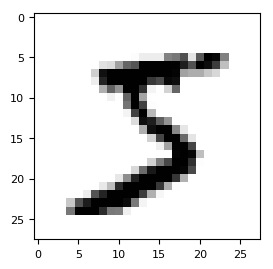

In [2]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); # Get the predictors X and the labels y
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.gray_r) # Take the first example, reshape to a 28x28 image and plot
print("Class label:",y[0]) # Print the correct class label

- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same but with 100 bootstrapping repeats. Are the results different? Explain.
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report is the optimal performance. Can you get better results than kNN?
    
Report all results clearly and interpret the results.  
Note: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.

### Solution

Predictive accuracy is 0.9688


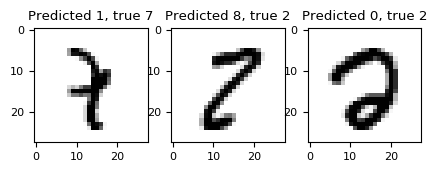

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random


if DEBUG:
    print('*** DEBUG RUN ***')
    Xtrain, ytrain, Xtest, ytest = \
        X[:600], y[:600], X[600:700], y[600:700]
else:
    Xtrain, ytrain, Xtest, ytest = \
        X[:60000], y[:60000], X[60000:], y[60000:]

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(Xtrain, ytrain);
ypred = knn.predict(Xtest);

print("Predictive accuracy is {}".format(
    accuracy_score(ytest, ypred)
))

mask_wrong = ytest != ypred
wrong, pred_wrong, y_wrong = \
    Xtest[mask_wrong], ypred[mask_wrong], ytest[mask_wrong]
for col in range(3):
    d = random.randint(0, wrong.shape[0] - 1)

    plt.subplot(1, 3, col + 1);
    plt.title("Predicted {}, true {}".format(
        pred_wrong[d], y_wrong[d])
    );
    plt.imshow(wrong[d].reshape(28, 28),
               cmap=plt.cm.gray_r);

plt.show();

The predictive accuracy is 0.9688, and most of the mis-classified images are actually easy to recognize.

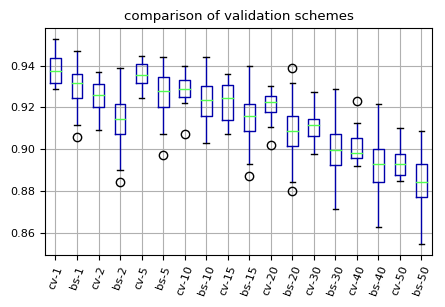

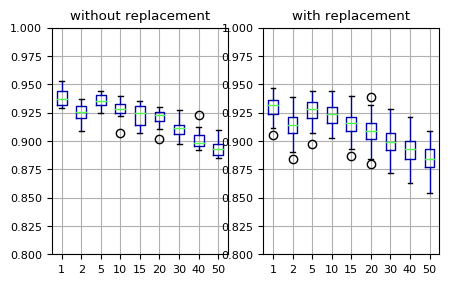

In [10]:
import itertools
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, \
    train_test_split, ShuffleSplit


if DEBUG:
    print('*** DEBUG RUN ***')

size = 0.005 if DEBUG else 0.1
x_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=size, stratify=y
)

scores = []
ks = [1, 2, 5, 10, 15, 20, 30, 40, 50]
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(
        knn, x_sample, y_sample, n_jobs=-1, cv=10
    ))
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(
        knn, x_sample, y_sample, n_jobs=-1, 
        cv=ShuffleSplit(100, train_size=0.66)
    ))
    print("finished k={}".format(k), ' ' * 10, end='\r')
print(' ' * 100)

plt.title('comparison of validation schemes');
idx = list(itertools.chain(*[
    ['cv-' + str(k), 'bs-' + str(k)] for k in ks
]));
axs = pd.DataFrame(scores, index=idx).transpose().boxplot();
plt.setp(axs.xaxis.get_majorticklabels(), rotation=70);
plt.show();

plt.subplot(1, 2, 1);
plt.ylim((0.8, 1.0));
plt.title('without replacement');
pd.DataFrame(scores[::2], index=ks).transpose().boxplot();

plt.subplot(1, 2, 2);
plt.ylim((0.8, 1.0));
plt.title('with replacement');
pd.DataFrame(scores[1::2], index=ks).transpose().boxplot();
plt.show();

According to the 10-fold cross-validation results, the best number of neighbors to consider is either 1 or 5; they perform very similarly, and the slight differences shown in the plots may well be due to randomness in the folds. The best value to pick is 5, because the resulting smoothing would give more accurate predictions when classifying ambiguous digits (especially those digits that are very different from any image in the dataset).

Cross-validation using sampling with and without replacement give similar results that strongly agree in the overall trend, but scores obtained via cross-validation are on average higher than the respective scores obtained via bootstrapping using the same $k$. This is expected, because the former used 90% for training, while the latter only 66%.

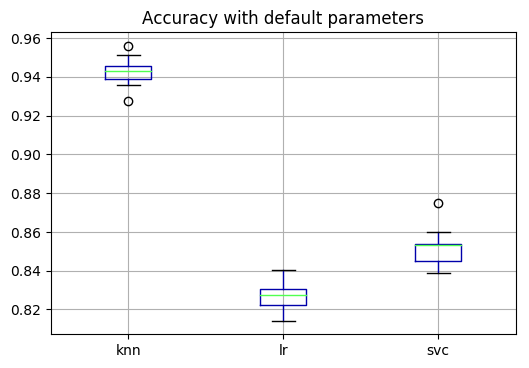

In [9]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,
    train_test_split, ShuffleSplit


if DEBUG:
    print('*** DEBUG RUN ***')
    
size = 0.005 if DEBUG else 0.1
Xtrain, _, ytrain, _ = train_test_split(X, y, train_size=size,
                                        stratify=y)

scores_knn = cross_val_score(KNeighborsClassifier(), Xtrain,
                             ytrain, n_jobs=-1, cv=10)
scores_lr = cross_val_score(LogisticRegression(), Xtrain
                            ytrain, n_jobs=-1, cv=10)
scores_svc = cross_val_score(LinearSVC(), Xtrain,
                             ytrain, n_jobs=-1, cv=10)

plt.title('Accuracy with default parameters')
pd.DataFrame(
    [scores_knn, scores_lr, scores_svc],
    index=['knn', 'lr', 'svc']
).transpose().boxplot();

Using the default parameters, k-nearest neighbors is by far the best model.

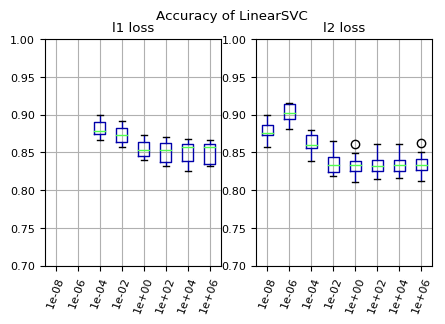

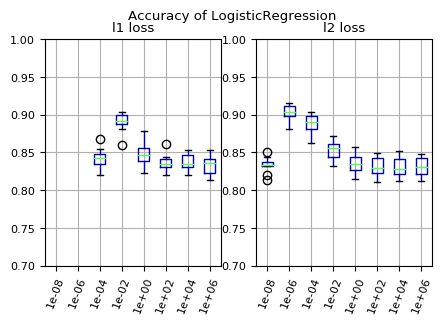

In [31]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, \
    train_test_split, ShuffleSplit

    
if DEBUG:
    print('*** DEBUG RUN ***')

size = 0.005 if DEBUG else 0.1
Xtrain, _, ytrain, _ = train_test_split(X, y, train_size=size,
                                        stratify=y)

def optimize_model(model_factory, cv=10):
    cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6]
    scores = []
    for loss in ['l1', 'l2']:
        for c in cs:
            model = model_factory(loss, c)
            scores.append(list(cross_val_score(
                model, Xtrain, ytrain, n_jobs=-1, cv=cv
            )))
            print('finished', loss, c, ' ' * 50, end='\r')
    print(' ' * 100)
    
    def plot(scores):
        plt.ylim((0.7, 1.0))
        
        axs = pd.DataFrame(
            scores, index=map('{:.0e}'.format, cs)
        ).transpose().boxplot()
        
        plt.setp(axs.xaxis.get_majorticklabels(),
                 rotation=70)
    
    plt.suptitle("Accuracy of {}".format(
        model.__class__.__name__, cv
    ))
    
    plt.subplot(1, 2, 1)
    plt.title('l1 loss')
    plot(scores[:len(cs)])
    
    plt.subplot(1, 2, 2)
    plt.title('l2 loss')
    plot(scores[len(cs):])
    
    plt.show()

optimize_model(lambda loss, c: LinearSVC(
    penalty=loss, C=c, dual=False
))

optimize_model(lambda loss, c: LogisticRegression(
    penalty=loss, C=c
))

Both with logistic regression and the linear SVC it is possible to achieve accuracies close to 0.9, but k-nearest neighbors is the best classification model as its accuracy is around 0.94. This means that the separation surface between the digits is almost, but not exactly linear, because linear models have, all in all, good performance, but a simple non-linear model is better.

Both linear models need quite a bit of regularization to achieve low validation error, meaning that there is significant overlap and ambiguity among the samples in the dataset. The choice of the loss does not significantly affect the maximum achievable performance, but it does influence the amount of regularization needed to reach it; L2 loss performs best with higher regularization than L1 loss.

## Model selection (4 points (2+2))
Study how RandomForest hyperparameters interact on the Ionosphere dataset (OpenML ID 59).

- Optimize a RandomForest, varying both $n\_estimators$ and $max\_features$ at the same time. Use a nested cross-validation and a grid search (or random search) over the possible values, and measure the AUC. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal AUC performance you find?
- Again, vary both hyperparameters, but this time use a grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow AUC$ with AUC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

Hint: Running this experiment can take a while, so start early and use a feasible grid/random search. Start with a coarse grid or few random search iterations.
Hint: Use a log scale (1,2,4,8,16,...) for $n\_estimators$. Vary $max\_features$ linearly between 1 and the total number of features. Note that, if you give $max\_features$ a float value, it will use it as [the percentage of the total number of features](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


### Solution

In [28]:
ionosphere = oml.datasets.get_dataset(59) # Download Ionosphere data
X, y = ionosphere.get_data(target=ionosphere.default_target_attribute); # Get the predictors X and the labels y

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import distributions
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_curve


if DEBUG:
    print('*** DEBUG RUN ***')
    
gs = RandomizedSearchCV(RandomForestClassifier(), param_distributions={
    'n_estimators': distributions.randint(1, 1000),
    'max_features': distributions.uniform(0, 1)
}, n_iter=(10 if DEBUG else 100), n_jobs=-1, cv=10, scoring='roc_auc');

scores = cross_val_score(gs,  X, y, cv=10)
print("Mean nested cross-validation score is {}, maximum is {}".format(
    scores.mean(), scores.max()
))

Best AUC is 0.9842806404958021, obtained with n_estimators = 32 and max_features = 0.1


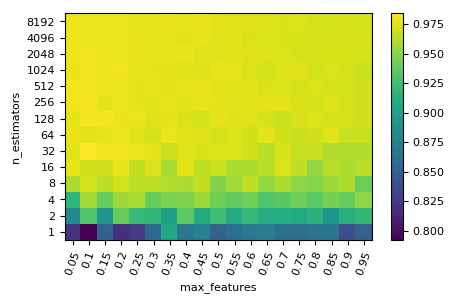

In [29]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import distributions
from sklearn.model_selection import GridSearchCV


if DEBUG:
    print('*** DEBUG RUN ***')

param_grid={
    'n_estimators': [1, 50, 100],
    'max_features': [0.1, 0.5, 0.9],
} if DEBUG else {
    'n_estimators': [2**x for x in range(14)],
    'max_features': np.arange(0.05, 1.0, 0.05),
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,
                  cv=10, n_jobs=-1, scoring='roc_auc');
gs.fit(X, y);

print('Best AUC is {}, obtained with n_estimators = {} and max_features = {}'.format(
    gs.best_score_, gs.best_params_['n_estimators'], gs.best_params_['max_features']
));

scores = np.array(gs.cv_results_['mean_test_score']).reshape(
    len(param_grid['max_features']),
    len(param_grid['n_estimators'])
).T;

img = mglearn.tools.heatmap(
    scores, cmap='viridis', fmt='',
    ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
    xlabel='max_features', xticklabels=param_grid['max_features'],
);

plt.colorbar(img);
plt.setp(img.get_axes().xaxis.get_majorticklabels(),
         rotation=70);
plt.show();

## Decision tree heuristics (1 point)
Consider the toy training set created below. It predicts whether your date agrees to go out with you depending on the weather.

Learn a decision tree:

- Implement functions to calculate entropy and information gain
- What is the class entropy for the entire dataset? What is the information gain when you split the data using the *Water* feature?
- Implement a basic decision tree:
    - Select a feature to split on according to its information gain. If multiple features are equally good, select the leftmost one.
    - Split the data and repeat until the tree is complete.
    - Print out the results (nodes and splits).
- Now train a scikit-learn decision tree on the same data. Do you get the same result? Explain.

In [20]:
df = pd.DataFrame({"Sky":['sunny','sunny','rainy','sunny','sunny'],
                   "AirTemp":['warm','warm','warm','cold','warm'],
                   "Humidity":['normal','high','high','high','normal'],
                   "Wind":['strong','strong','strong','strong','weak'],
                   "Water":['warm','warm','cool','warm','warm'],
                   "Forecast":['same','same','change','change','same'],
                   "Date?":['yes','yes','no','yes','no']
                   });
df = df[['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']] # Fix column ordering
df # print

,Sky,AirTemp,Humidity,Wind,Water,Forecast,Date?
0,sunny,warm,normal,strong,warm,same,yes
1,sunny,warm,high,strong,warm,same,yes
2,rainy,warm,high,strong,cool,change,no
3,sunny,cold,high,strong,warm,change,yes
4,sunny,warm,normal,weak,warm,same,no


### Solution

In [21]:
import math
from collections import defaultdict


def entropy(values):
    n_pos = values.sum()
    p = float(n_pos) / len(values)
    return -p * math.log(p, 2) if p > 0 else 0

def info_gain(pos1,neg1,pos2,neg2):
    return entropy(pos2, neg2) - entropy(pos1, neg1)

def split(data, variable):
    grouped = data.groupby(variable)
    total_entropy = 0.0
    for key, group in grouped:
        ent = entropy(group['Date?'] == 'yes')
        total_entropy += ent * len(group) / len(data)
    return total_entropy

def build_decision_tree(data, target):
    def do_split(data, columns, indent=0, verbose=True):
        def log(*args):
            print(' ' * indent, *args)
        
        def finalize():
            pyes = float((data[target] == 'yes').sum()) / len(data) 
            pred, prob = ('yes', pyes) if pyes >= 0.5 else ('no', 1 - pyes)
            log('Prediction: {} with probability {}'.format(
                pred, prob
            ))
        
        if not columns:  # no more attributes to split on
            finalize()
            return
        
        # try all possible splits
        base_entropy = entropy(data[target] == 'yes')
        best = None
        for each in columns:
            ent = split(data, each)
            if verbose:
                log('--> information gain when splitting on {} is {}'.format(
                    each, base_entropy - ent
                ))
                
            if not best or ent < best[1]:
                best = each, ent
        
        # if a split improves classification recurse
        # otherwise stop and print classification
        ig = base_entropy - best[1]
        if ig > 0:
            log('Split on {} (information gain = {})'.format(
                best[0], ig
            ))
            
            new_columns = [c for c in columns if c != best[0]]
            for key, group in data.groupby(best[0]):
                nyes = (group[target] == 'yes').sum()
                log('{} = {} (yes = {}, no = {})'.format(
                    best[0], key, nyes, len(group) - nyes
                ))
                do_split(group, new_columns, indent + 2, verbose)
        else:
            log('Not splitting (no information gain)')
            finalize()
            
    print('===  Decision tree for', target)
    columns = [c for c in data.columns if c != target]
    do_split(data, columns, verbose=True)

initial_ent = entropy(df['Date?'] == 'yes')
water_ent = split(df, 'Water')

print('The initial entropy is', initial_ent)
print('The information gain after splitting on water is',
      initial_ent - water_ent)

build_decision_tree(df, 'Date?')

The initial entropy is 0.44217935649972373
The information gain after splitting on water is 0.19315685693241746
===  Decision tree for Date?
 --> information gain when splitting on Sky is 0.19315685693241746
 --> information gain when splitting on AirTemp is 0.04217935649972371
 --> information gain when splitting on Humidity is 0.008194356211261189
 --> information gain when splitting on Wind is 0.19315685693241746
 --> information gain when splitting on Water is 0.19315685693241746
 --> information gain when splitting on Forecast is 0.008194356211261189
 Split on Sky (information gain = 0.19315685693241746)
 Sky = rainy (yes = 0, no = 1)
   --> information gain when splitting on AirTemp is 0.0
   --> information gain when splitting on Humidity is 0.0
   --> information gain when splitting on Wind is 0.0
   --> information gain when splitting on Water is 0.0
   --> information gain when splitting on Forecast is 0.0
   Not splitting (no information gain)
   Prediction: no with probabil

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

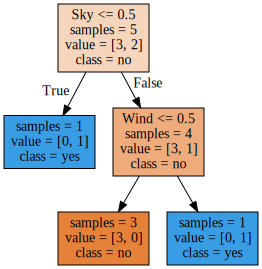

In [22]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

new_df = df.copy()
for col in new_df:
    for i, val in enumerate(set(new_df[col])):
        #print('{} = {} translated to {}'.format(col, val, i))
        new_df.loc[new_df[col] == val, col] = i

features = ['AirTemp','Forecast','Humidity','Sky','Water','Wind']
X = np.array(new_df[features], dtype=np.int)
y = np.array(new_df[['Date?']], dtype=np.int)

dc = DecisionTreeClassifier(criterion='entropy');
dc.fit(X, y);

export_graphviz(dc, out_file="tree.dot", class_names=["no", "yes"], 
                feature_names=features, impurity=False, filled=True);

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

Apparently, when multiple splits yield the same information gain, scikit choses a random one, whereas the version implemented above deterministically choses the first such split; after a few trials, it is possible to obtain the same decision tree.

## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy  
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself.

In [9]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

### Solution

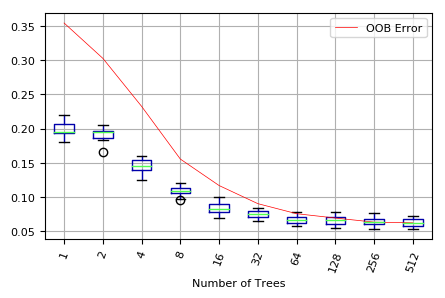

In [24]:
from numpy.random import permutation
from sklearn import ensemble
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold


DEBUG = False
if DEBUG:
    print('*** DEBUG RUN ***')
    n_trees = [1, 10, 50]
else:
    n_trees = [2**i for i in range(10)]

# shuffle data (not doing it causes problems with cross validation)
perm = permutation(X.shape[0])
X = X[perm]
y = y[perm]

scores_cv, scores_oob = [], []
for nt in n_trees:
    rfc = ensemble.RandomForestClassifier(
        n_estimators=nt, oob_score=True, n_jobs=-1
    );
    rfc.fit(X, y);
    scores_oob.append(1 - rfc.oob_score_);
    
    rfc = ensemble.RandomForestClassifier(n_estimators=nt);
    accuracies = cross_val_score(rfc, X, y, cv=10,
                                 n_jobs=-1, scoring='accuracy')
    scores_cv.append([1 - acc for acc in accuracies])

plt.xlabel('Number of Trees')
df = pd.DataFrame(scores_cv, index=n_trees);
df.T.boxplot(rot=70);
plt.plot(range(1, len(scores_oob) + 1), scores_oob, 'r-', label='OOB Error')
plt.legend(loc='best')
plt.show();

The OOB error tends to be higher than the 10-fold cross validation error, especially with few trees; as the number of trees grows, the two converge to the same value. It makes sense because, when computing the OOB error, the prediction for a sample is obtained from a smaller number of trees, roughly two thirds of the trees in the forest.

## A regression benchmark (1 point)
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

In [ ]:
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);